## Bit of basic quantitative analysis of a 2D scalar field (equivalent to image analysis) - eg vorticity or speed of a fluid


RPS, 2024

Below written to work with vorticity but will work with any 2D scalar field, eg speed of flow, but for that will need threshold adjusting. 

Note that a scalar field in 2D is a 2D array of numbers, in Python a 2D numpy array, with each number being the speed or vorticity or ... at a point. A greyscale* image is also a 2D array of numbers, with each number being how light the image is at that point (pixel). So quantitative analysis of a 2D scalar field (such as speed) and quantitative analysis of a greyscale image are exactly the same problem. Because of the this we will use [opencv](https://opencv.org/) which describes itself as for "Computer Vision" to analyse our scalar fields to locate vortices, and quantify how large they are.

*A greyscale image is an image where each pixel is grey, i.e., each pixel ranges from black through dark grey, light grey and white. A colour image is typically three arrays of the same size, one array of numbers where each number is how red that pixel is, one for how green each pixel is and one for how blue each pixel is. 

Below uses "cv2" which comes from [opencv](https://opencv.org/). See [here](https://docs.opencv.org/4.x/da/df6/tutorial_py_table_of_contents_setup.html) for an intro and help installing. On a Uni linux machine you will need to install opencv, try opening a terminal and typing

pip install --user opencv-python

On Windows machine maybe use pip not anaconda to instal opencv (which gives you cv2), if you have a standard conda python installation try 

pip install opencv-python

in a conda shell

cv2 aka opencv is a very common Python package doing something many many people need to do - analyse images - so if you have a problem just Google etc it and look at stack overflow etc. Also there are many many webpages, YouTube videos etc etc on cv

**NB It is important to note that image analysis is just analysis of arrays of numbers, a gray image is just a 2D array of numbers, like the numpy arrays you are used to**

In [1]:
from matplotlib import pyplot as plt
import numpy as np
#
import cv2
#
import os
#from google.colab import drive
#drive.mount('/content/drive')

Read in ("pickled") file with vorticity array... NB pickle is just an efficient way of saving numpy arrays etc for reading in by another program. Usually in science we have at least two Python programs, one that generates data and another that analyses the data.

NB code can be edited to make it work with any other scalar field

just change file_name to change the file read in

In [2]:
# assumes there is a directory called pngs already in directory this code runs in
directory = 'data'
file_name = "uvort1004375.npz"
file_path = os.path.join(directory, file_name)
print('opening file ',file_path)
# with hopefully close .npz file at end
with np.load(file_path) as npzfile:
    print(npzfile.files)
    vorticity=npzfile['vorticity']
    u=npzfile['u']
    time=npzfile['time']
    Re=npzfile['Re']
    x0=npzfile['x0']
    y0=npzfile['y0']
    r=npzfile['r']
print('read in vorticity array of size',vorticity.shape)
nx,ny=vorticity.shape
print('data at time ',time,' from run at Reynolds number ', Re)
print('cylinder radius ',r,' at ',x0,y0)
#
binary=np.zeros((nx,ny))#,dtype=int)
for i in range(0,nx):
    for j in range(0,ny):
# disc obstacle
        if( (i-x0)**2 + (j-y0)**2 < r**2  ): 
# inside obstacle
            binary[i,j]=1
#
min_vort=np.amin(vorticity)
max_vort=np.amax(vorticity)
print('vorticity ranges from ',min_vort,' to ',max_vort)


opening file  data\uvort1004375.npz
['u', 'vorticity', 'x0', 'y0', 'r', 'Re', 'time', 'allow_pickle']
read in vorticity array of size (250, 140)
data at time  7.291666666666667  from run at Reynolds number  100
cylinder radius  12  at  50.0 70.0
vorticity ranges from  -0.08553320920710632  to  0.08578271119531386


### First plot the configuration

Now we do a plot of vorticity field (a scalar field) plus a quiver (arrow) plot of the velocity vector field, using the configuration we have just read in. It is good practice to see what a configuration looks like before doing any quantitative analysis.

shape of quiver plotting  (25, 14)


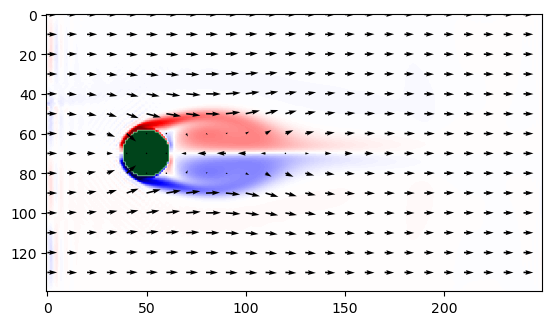

In [3]:
n_coarse=10
ux_plot=np.transpose(u[0,::n_coarse,::n_coarse])*(1.0-np.transpose(binary[::n_coarse,::n_coarse]))
uy_plot=np.transpose(u[1,::n_coarse,::n_coarse])*(1.0-np.transpose(binary[::n_coarse,::n_coarse]))
print('shape of quiver plotting ',u[0,::n_coarse,::n_coarse].shape)
nx_plot,ny_plot=u[0,::n_coarse,::n_coarse].shape
x_plot=np.zeros((nx_plot,ny_plot))
y_plot=np.zeros((nx_plot,ny_plot))
for i in range(0,nx_plot):
    for j in range(0,ny_plot):
        x_plot[i,j]=float(i)*n_coarse
        y_plot[i,j]=float(j)*n_coarse
# NB making scale number bigger makes arrows smaller!
plt.quiver(np.transpose(x_plot),np.transpose(y_plot),ux_plot,uy_plot,scale=2)
#plt.imshow(np.transpose(vorticity),cmap='gray')
plt.imshow(np.transpose(vorticity),cmap='seismic', \
                      alpha=np.transpose(1.0-binary),vmin=-0.05,vmax=0.05)
plt.imshow(np.transpose(binary), \
                   cmap='Greens',alpha=np.transpose(binary))
plt.show()

### Quantitative analysis of vorticity scalar field



First slice array to remove the disc - so just looking at vortices downstream.

vorticity array now of size (186, 140)


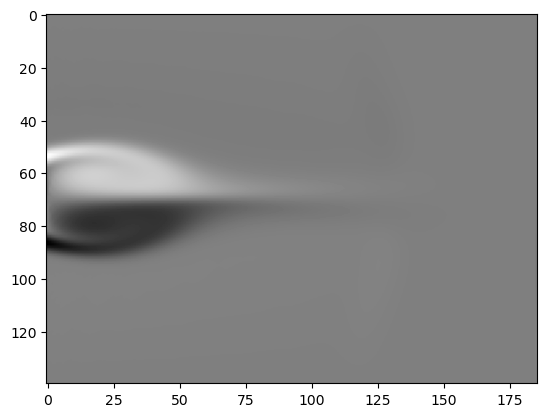

In [4]:
vorticity_crop=vorticity[int(x0+r+2):,:]
print('vorticity array now of size',vorticity_crop.shape)
plt.imshow(np.transpose(vorticity_crop),cmap='gray')
plt.show()

Get histogram of array values to see what distribution is. This helps with picking a value for the threshold.

26040  pixels


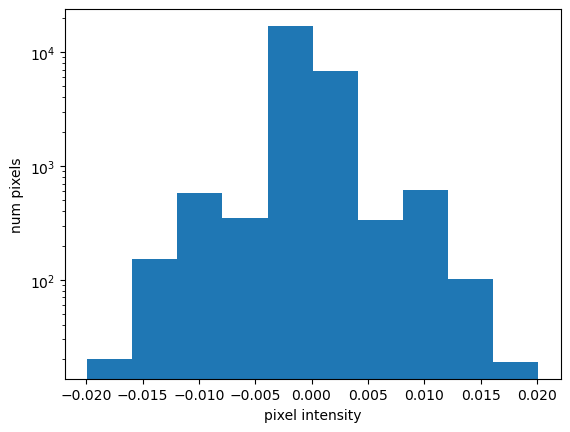

In [5]:
array1d=vorticity_crop.flatten()
print(len(array1d),' pixels')
plt.hist(array1d)
plt.xlabel('pixel intensity')
plt.ylabel('num pixels')
plt.yscale('log')

Below uses cv2.threshold function to create an array of the same size as the vorticity array but with all array values either 1, for vorticity value above (not equal to) the threshold, or 0, for vorticity value below the threshold.

Note this threshold value is selected by trial and error, feel free to play around with the number.



initially counting all pixels with intensity greater than  0.002  as in fibres
float64
uint8
(186, 140)


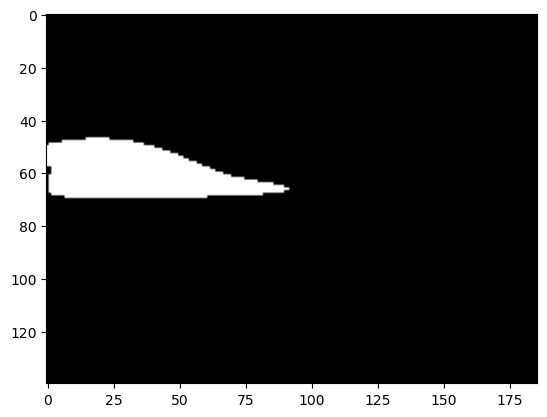

note image now binary, black/white


In [6]:
threshold_value=0.002
print('initially counting all pixels with intensity greater than ',threshold_value,' as in fibres')
ret,binary_image = cv2.threshold(vorticity_crop,threshold_value,1,cv2.THRESH_BINARY)
#
print(binary_image.dtype)
binary_image=binary_image.astype('uint8')
print(binary_image.dtype)
print(binary_image.shape)
# display the array of pixels as an image
plt.imshow(np.transpose(binary_image),cmap='gray')#, vmin = 0, vmax = 255)
plt.show()
print('note image now binary, black/white')

Now use the clustering algorithm from OpenCV.

The clustering algorithm from Open CV works to find patches of array elements above the threshold, i.e., works to connect clusters of **white** pixels. So image should be disconnected clusters of white pixels in a black background. Patches of black pixels in a continuous white background will not work, I think.

cv2.bitwise_not is probably the cv command you need if you need to flip the image.




found  1  clusters, ie separate sets of above threshold pixels


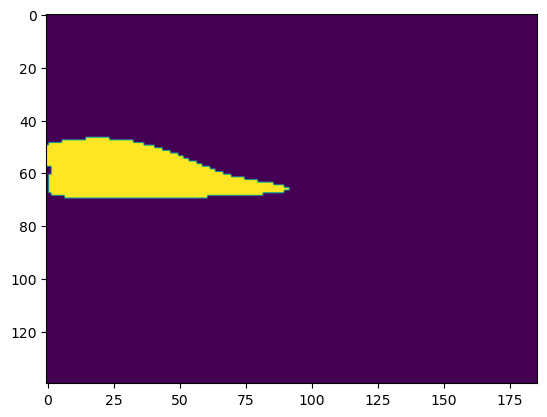

(186, 140)


In [7]:
numLabels, labels,stats,centroids = cv2.connectedComponentsWithStats(binary_image)
print('found ',numLabels -1, \
      ' clusters, ie separate sets of above threshold pixels')
plt.imshow(np.transpose(labels))
plt.show()
print(labels.shape)


Below loops over clusters greater than some threshold size, printing out size and location

In [8]:
min_cluster_size=100
# loop over the number of unique connected component labels, skipping
# over the first label (as label zero is the background)
for i in range(1, numLabels):
# extract the connected component statistics for the current
# label
   x = stats[i, cv2.CC_STAT_LEFT]
   y = stats[i, cv2.CC_STAT_TOP]
   w = stats[i, cv2.CC_STAT_WIDTH]
   h = stats[i, cv2.CC_STAT_HEIGHT]
   area = stats[i, cv2.CC_STAT_AREA]
   if(area>min_cluster_size):
       print('cluster ',i,' has area = ',area, \
             ' located at x',round(centroids[i,0],1),' y ', \
             round(centroids[i,1],1))

cluster  1  has area =  1373  located at x 60.0  y  34.2


Cell below may or may not needed, it just removes clusters below a specified size ...

removing connected clusters of pixels with less than  100  pixels
number of clusters remaining  1


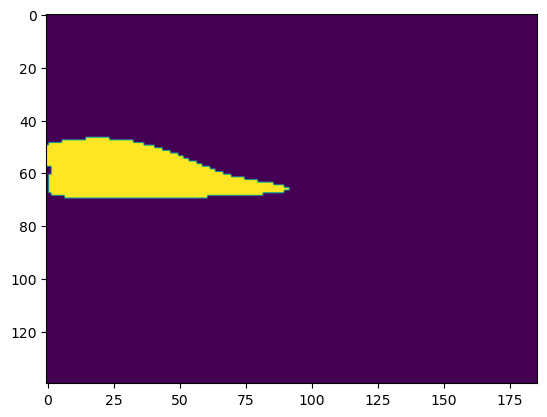

In [9]:
num_clusters=numLabels-1
print('removing connected clusters of pixels with less than ',min_cluster_size,' pixels')
for i in range(1,numLabels):
    pts =  np.where(labels == i)
#    print(i,len(pts[0]))#,len(pts[1]))
    if len(pts[0]) < min_cluster_size:
        labels[pts] = 0
        num_clusters=num_clusters-1
        print('removing tiny possible fibre of ',len(pts[0]),' pixels')

print('number of clusters remaining ',num_clusters)
plt.imshow(np.transpose(labels))#,cmap='gray')#, vmin = 0, vmax = 255)
plt.show()